In [2]:
%%capture
%pip install -r ../requirements.txt

In [3]:
from schema import WLD

wld = WLD(file_path="../data/example-chappy.wld")

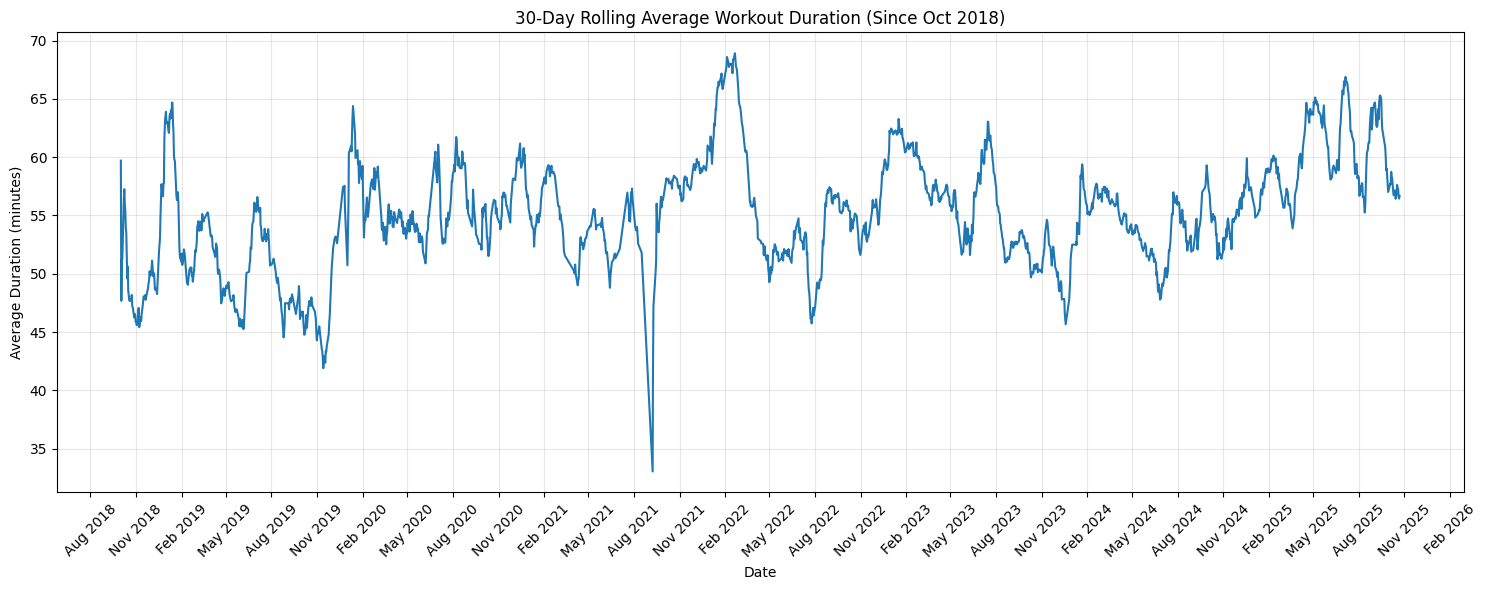

Overall average workout duration: 55.2 minutes
Highest 30-day average: 68.9 minutes
Lowest 30-day average: 33.0 minutes


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Extract workout dates and durations
workout_data = []
for workout in wld.workouts:
    workout_data.append(
        {
            "date": workout.date,
            "duration": workout.duration / 60,  # Convert seconds to minutes
        }
    )

# Convert to DataFrame
df = pd.DataFrame(workout_data)
df["date"] = pd.to_datetime(df["date"])

# Filter data from October 2018 onwards
df = df[df["date"] >= "2018-10-01"]

# Calculate 30-day rolling average
df = df.sort_values('date')
rolling_avg = df.set_index('date')['duration'].rolling('30D').mean()

# Create the plot
plt.figure(figsize=(15, 6))
plt.plot(rolling_avg.index, rolling_avg.values, linestyle="-")

# Format the plot
plt.title("30-Day Rolling Average Workout Duration (Since Oct 2018)")
plt.xlabel("Date")
plt.ylabel("Average Duration (minutes)")
plt.grid(True, alpha=0.3)

# Format x-axis to show dates nicely
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Overall average workout duration: {df['duration'].mean():.1f} minutes")
print(
    f"Highest 30-day average: {rolling_avg.max():.1f} minutes"
)
print(
    f"Lowest 30-day average: {rolling_avg.min():.1f} minutes"
)

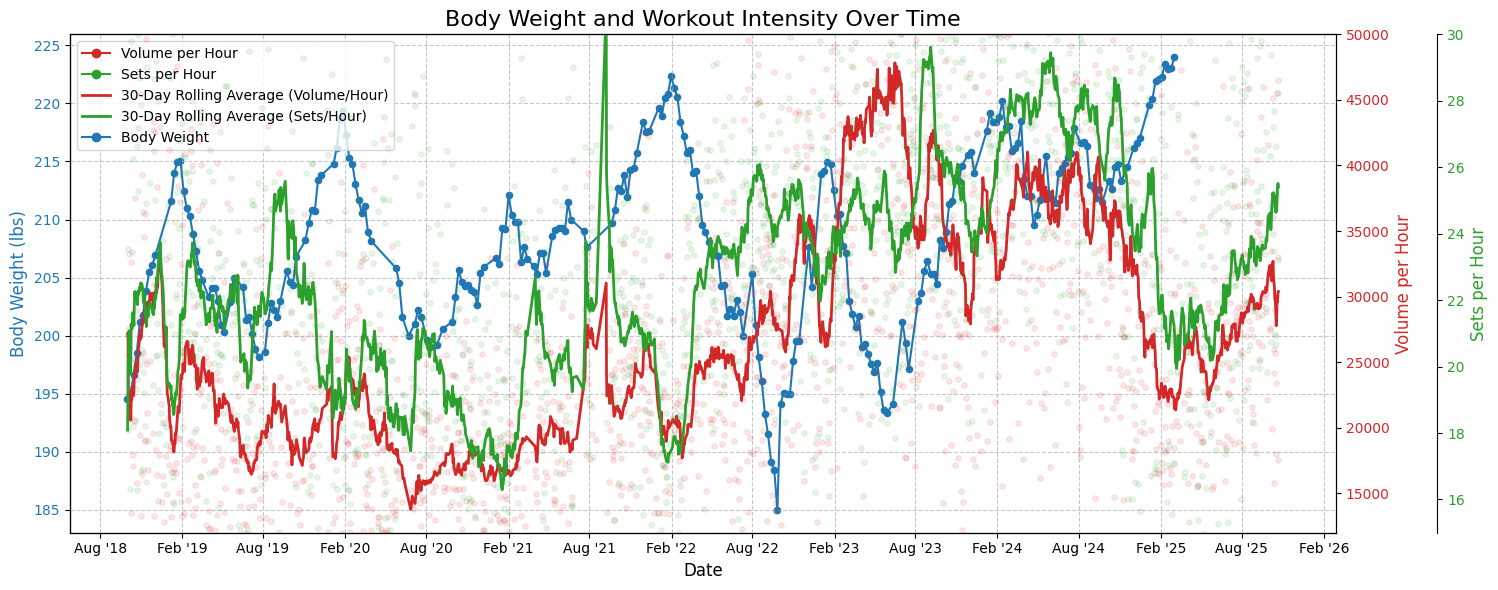

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter

# Load the weight data
df = pd.read_csv("../data/weight.csv")

# Convert 'Week of' to datetime for weight data
excel_epoch = datetime(1899, 12, 30)
df["Date"] = df["Week of"].apply(lambda x: excel_epoch + timedelta(days=int(x)))
df_clean = df.dropna(subset=["Average"])

# Filter data from October 2018 onwards
df_clean = df_clean[df_clean["Date"] >= "2018-10-01"]

# Create complete date range and interpolate weight data
date_range = pd.date_range(
    start=df_clean["Date"].min(), end=df_clean["Date"].max(), freq="7D"
)
df_complete = pd.DataFrame({"Date": date_range})
df_merged = pd.merge(df_complete, df_clean, on="Date", how="left")
df_merged["Average_Interpolated"] = df_merged["Average"].interpolate(method="linear")

# Extract workout volumes, durations and dates
workout_data = []
for workout in wld.workouts:
    workout_data.append({
        "Date": workout.date,
        "Volume": workout.volume(),
        "Sets": workout.numSets(),
        "Duration": workout.duration / 3600,  # Convert seconds to hours
    })
workout_df = pd.DataFrame(workout_data)

# Filter workout data from October 2018 onwards
workout_df = workout_df[workout_df["Date"] >= "2018-10-01"]

# Calculate rolling sums first
workout_df = workout_df.sort_values('Date')
rolling_volume_sum = workout_df.set_index('Date')['Volume'].rolling('30D').sum()
rolling_sets_sum = workout_df.set_index('Date')['Sets'].rolling('30D').sum()
rolling_duration_sum = workout_df.set_index('Date')['Duration'].rolling('30D').sum()

# Calculate per-hour metrics from rolling sums
rolling_volume_per_hour = rolling_volume_sum / rolling_duration_sum
rolling_sets_per_hour = rolling_sets_sum / rolling_duration_sum

# Calculate individual workout per-hour metrics for scatter plot
workout_df["VolumePerHour"] = workout_df["Volume"] / workout_df["Duration"]
workout_df["SetsPerHour"] = workout_df["Sets"] / workout_df["Duration"]

# Create the plot with three y-axes
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot weight data on primary y-axis
color = "tab:blue"
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Body Weight (lbs)", color=color, fontsize=12)
ax1.plot(df_merged["Date"], df_merged["Average_Interpolated"], "-", color=color)
ax1.scatter(df_clean["Date"], df_clean["Average"], s=20, color=color)
ax1.tick_params(axis="y", labelcolor=color)
ax1.grid(True, linestyle="--", alpha=0.7)

# Create secondary y-axis for volume metrics
ax2 = ax1.twinx()
color = "tab:red"
ax2.set_ylabel("Volume per Hour", color=color, fontsize=12)

# Plot volume metrics
ax2.scatter(workout_df["Date"], workout_df["VolumePerHour"], color=color, alpha=0.1, s=15, label="Volume per Hour")
ax2.plot(
    rolling_volume_per_hour.index,
    rolling_volume_per_hour.values,
    color=color,
    linewidth=2,
    label="30-Day Rolling Average (Volume/Hour)",
)
ax2.tick_params(axis="y", labelcolor=color)
ax2.set_ylim(12_000, 50_000)

# Create tertiary y-axis for sets metrics
ax3 = ax1.twinx()
color = "tab:green"
ax3.spines["right"].set_position(("axes", 1.08))  # Offset the third axis
ax3.set_ylabel("Sets per Hour", color=color, fontsize=12)

# Plot sets metrics
ax3.scatter(workout_df["Date"], workout_df["SetsPerHour"], color=color, alpha=0.1, s=15, label="Sets per Hour")
ax3.plot(
    rolling_sets_per_hour.index,
    rolling_sets_per_hour.values,
    color=color,
    linewidth=2,
    label="30-Day Rolling Average (Sets/Hour)",
)
ax3.tick_params(axis="y", labelcolor=color)
ax3.set_ylim(15, 30)

# Format x-axis to show dates nicely
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b '%y"))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation=45)

# Add title and legend
plt.title("Body Weight and Workout Intensity Over Time", fontsize=16)

# Add custom legend
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color="tab:red", marker="o", label="Volume per Hour"),
    Line2D([0], [0], color="tab:green", marker="o", label="Sets per Hour"),
    Line2D([0], [0], color="tab:red", linewidth=2, label="30-Day Rolling Average (Volume/Hour)"),
    Line2D([0], [0], color="tab:green", linewidth=2, label="30-Day Rolling Average (Sets/Hour)"),
    Line2D([0], [0], color="tab:blue", marker="o", label="Body Weight"),
]
ax1.legend(handles=legend_elements, loc="upper left")

plt.tight_layout()
plt.show()